In [68]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.experimental import enable_iterative_imputer
from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, cross_val_predict, train_test_split
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler

### MNIST Dataset
In this lecture we will be using the MNIST dataset, which is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. We will download the dataset directly from `sklearn`.

In [2]:
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

c:\Users\musab\anaconda3\lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Datasets loaded by `Scikit-Learn` generally have a similar dictionary structure, including the following:
- A DESCR key describing the dataset
- A data key containing an array with one row per instance and one column per feature
- A target key containing an array with the labels

In [11]:
X = mnist["data"]
y = mnist["target"]

In [12]:
X.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
y.head()

0    5
1    0
2    4
3    1
4    9
Name: class, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

### Exploratory Analysis

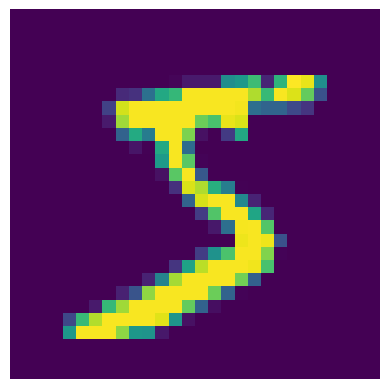

In [31]:
digit = X.iloc[0, :].values
digit_image = digit.reshape(28, 28)
plt.imshow(digit_image)
plt.axis("off")
plt.show()

### Binary Classifier

We will develop a binary classifier that can classify whether a digit is $5$ or not. First, we will convert our targets into numeric data type because it is in string format by default.

In [20]:
y = y.astype(np.uint8)

In [21]:
y.head()

0    5
1    0
2    4
3    1
4    9
Name: class, dtype: uint8

The MNIST dataset is already splitted into train and test data. The first $60,000$ data is for training and the rest are for testing purpose. Therefore, we won't be using the `train_test_split` now.

In [23]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Next, we will set all the targets where the value is $5$ as $True$ or $1$, and the rest as $False$ or $0$. 

In [28]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

### Modelling

In [29]:
sgd_clf = SGDClassifier(
    loss='log_loss',
    penalty='l1',
    alpha=0.5,
    fit_intercept=True,
    verbose=0,
    learning_rate='constant',
    eta0=0.01,
    early_stopping=True,
    n_iter_no_change=20,
    tol=1e-3,
    random_state=42
)

sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.5, early_stopping=True, eta0=0.01,
              learning_rate='constant', loss='log_loss', n_iter_no_change=20,
              penalty='l1', random_state=42)

In [32]:
sgd_clf.predict([digit])

c:\Users\musab\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

### Cross-Validation

The `StratifiedKFold` class performs stratified sampling to produce folds that contain a representative ratio of each class. At each iteration the code creates a clone of the classifier, trains that clone on the training folds, and makes predictions on the test fold. Then it counts the number of correct predictions and outputs the ratio of correct predictions.

In [34]:
skfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    
    X_train_folds = X_train.loc[train_index]
    y_train_folds = y_train_5.loc[train_index]
    
    X_test_fold = X_train.loc[test_index]
    y_test_fold = y_train_5.loc[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9109166666666667
0.934
0.9150833333333334
0.9434166666666667
0.9158333333333334


However, if you do not want this much control over each iteration, you can simply use [`cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html).

In [35]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=5, scoring="accuracy")

array([0.93416667, 0.94891667, 0.93975   , 0.94283333, 0.94908333])

### Model Evaluation

Remember that you want to use the test set only at the very end of your project, once you have a classifier that you are ready to launch). Instead, you can use the `cross_val_predict` function. Just like the `cross_val_score` function, `cross_val_predict` performs K-fold cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold. This means that you get a clean prediction for each instance in the training set. “clean” meaning that the prediction is made by a model that never saw the data during training.

In [36]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Each row in a confusion matrix represents an actual class, while each column represents a predicted class.

In [38]:
confusion_matrix(y_train_5, y_train_pred)

array([[53214,  1365],
       [ 2057,  3364]], dtype=int64)

An interesting one to look at is the accuracy of the positive predictions; this is called the precision of the classifier.

In [39]:
precision_score(y_train_5, y_train_pred)

0.7113554662719391

Precision is typically used along with another metric named recall, also called sensitivity or the true positive rate (TPR): this is the ratio of positive instances that are correctly detected by the classifier.

In [40]:
recall_score(y_train_5, y_train_pred)

0.6205497140748939

Classifier will only get a high F score if both recall and precision are high.

In [41]:
f1_score(y_train_5, y_train_pred)

0.6628571428571429

# Titanic

### Data Loading

In [44]:
titanic = pd.read_csv('./data/titanic.csv')
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Data Preprocessing

In [45]:
X = titanic.iloc[:, [2, 4, 5, 6, 7, 9]]
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare
0,3,male,22.0,1,0,7.2500
1,1,female,38.0,1,0,71.2833
2,3,female,26.0,0,0,7.9250
3,1,female,35.0,1,0,53.1000
4,3,male,35.0,0,0,8.0500


In [46]:
X.shape

(891, 6)

In [47]:
y = titanic.iloc[:, 1]
y.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

### Missing Value

In [49]:
X.isna().sum()

Pclass      0
Sex         0
Age       177
SibSp       0
Parch       0
Fare        0
dtype: int64

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=25)

### Data Imputation

In [58]:
imputer = IterativeImputer()
imputer.fit(X_train[['Age']])
X_train[['Age']] = imputer.transform(X_train[['Age']])
X_test[['Age']] = imputer.transform(X_test[['Age']])

In [59]:
X_train.isna().sum(axis=0)

Pclass    0
Sex       0
Age       0
SibSp     0
Parch     0
Fare      0
dtype: int64

In [60]:
X_test.isna().sum(axis=0)

Pclass    0
Sex       0
Age       0
SibSp     0
Parch     0
Fare      0
dtype: int64

### Data Encoding

In [61]:
X_train_enc = pd.get_dummies(X_train)
X_test_enc = pd.get_dummies(X_test)

In [62]:
pd.DataFrame(X_train_enc).head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male
161,2,40.0,0,0,15.750,True,False
776,3,28.0,0,0,7.750,False,True
280,3,65.0,0,0,7.750,False,True
276,3,45.0,0,0,7.750,True,False
598,3,28.0,0,0,7.225,False,True


### Standardization

In [ ]:
std = StandardScaler()
std.fit(X_train_enc)

X_train_enc = std.transform(X_train_enc)
X_test_enc = std.transform(X_test_enc)

### Modeling

In [66]:
reg = LogisticRegression()
reg.fit(X_train_enc, y_train)

LogisticRegression()

### Evaluation

In [67]:
train_preds = reg.predict(X_train_enc)
test_preds = reg.predict(X_test_enc)

In [69]:
print('Train Accuracy: ', accuracy_score(y_train, train_preds))
print('Test Accuracy: ', accuracy_score(y_test, test_preds))

Train Accuracy:  0.8008982035928144
Test Accuracy:  0.7892376681614349
